In [19]:
# External libraries
import pandas as pd
import numpy as np
import janitor
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Features engineersing
from sklearn.preprocessing import StandardScaler

# Own libraries
sys.path.append(os.path.abspath("../scripts"))
import utils

In [20]:

# Cargar datos
train_data = pd.read_csv("../data/raw/base_train.csv", sep="|")
valid_data = pd.read_csv("../data/raw/base_validacion.csv", sep="|")
test_data = pd.read_csv("../data/raw/base_prueba.csv", sep="|")

In [21]:
train_data.shape # 28 mil datos - 28 columnas

(28276, 28)

# Revisiones generales

En este apartado se propone revisar el estado actual de la informacion. Datos faltantes, lecutra correcta y tipo de datos (consistentes con el diccionario).

In [22]:
print('Datos faltantes\n',
      '============================\n', 
      train_data.isnull().sum())


Datos faltantes
 num_doc         0
f_analisis      0
default         0
tipo_cliente    0
trx39           0
trx102          0
trx106          0
trx143          0
trx158          0
disp309         0
CO01END010RO    0
CO01ACP017CC    0
CO02EXP011TO    0
CO02EXP004TO    0
CO01EXP001CC    0
CO01EXP003RO    0
CO02END015CC    0
CO01END002RO    0
CO01END086RO    0
CO01END094RO    0
CO02NUM086AH    0
CO02NUM043RO    0
CO01EXP002AH    0
CO01NUM002AH    0
CO01END051RO    0
CO01ACP011RO    0
CO02MOR092TO    0
CO01MOR098RO    0
dtype: int64


`No hay datos faltantes`

In [23]:
# train_data.describe().shape # todo lo tomo numerico
train_data.describe()

,num_doc,f_analisis,default,trx39,trx102,trx106,trx143,trx158,disp309,CO01END010RO,...,CO01END086RO,CO01END094RO,CO02NUM086AH,CO02NUM043RO,CO01EXP002AH,CO01NUM002AH,CO01END051RO,CO01ACP011RO,CO02MOR092TO,CO01MOR098RO
count,2.827600e+04,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,...,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000
mean,4.974533e+11,201808.536285,0.067372,0.675212,0.009988,0.009386,0.157412,0.106482,6.727401,1.714396,...,36.270536,6.353860,44.648904,35.537686,8.179233,2.629898,5.007108,0.180259,72.962840,48.529336
std,2.875796e+11,3.231793,0.250669,1.003746,0.070848,0.068895,0.284814,0.225333,3.952865,4.576126,...,39.832468,13.412629,23.386687,35.573957,13.073666,1.239205,17.239716,2.223357,42.869349,48.958556
min,5.257814e+07,201801.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,...,-4.000000,-4.000000,-3.000000,-1.000000,-1.000000,-1.000000,-4.000000,-3.000000,-3.000000,-3.000000
25%,2.500376e+11,201806.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-1.000000,...,-1.000000,-1.000000,28.570000,0.000000,2.000000,2.000000,-1.000000,-1.000000,47.346860,-1.000000
50%,4.949118e+11,201810.000000,0.000000,0.276385,0.000000,0.000000,0.014986,0.008533,7.000000,0.490000,...,25.670000,2.560000,40.000000,33.330000,6.000000,2.000000,0.700000,0.000000,100.000000,55.881760
75%,7.456302e+11,201811.000000,0.000000,0.953794,0.000006,0.000005,0.185602,0.103468,10.000000,2.700000,...,68.532500,7.680000,57.140000,66.670000,12.000000,3.000000,4.410000,1.000000,100.000000,100.000000
max,9.999384e+11,201812.000000,1.000000,13.231644,2.688028,2.688028,3.755929,3.038751,12.000000,90.030000,...,1276.110000,512.010000,100.000000,100.000000,673.000000,13.000000,872.320000,59.000000,100.000000,100.000000


In [24]:
print(train_data['default'].value_counts(normalize=True))

default
0    0.932628
1    0.067372
Name: proportion, dtype: float64


Como era de esperarse del poderosisimo equipo de Bancolombia, aproximadamente el 93.3 % de los clientes cumplieron los pagos (categorida default = 0) y aproximadamente el 6.7 % de los clientes incumplieron con el pago. 

`Por si solos, estos nombres no dicen mucho. Cambio de nombres!`

Con ChatGPT vamos a crear el diccionario base y una vez lo tengamos, se revisa uno a uno para tener informacion relevante a la mano. 

In [25]:
nombre_actual_a_nuevo = { # Convencion: 
                         # Si termina Telcos -> portafolio productos telcos
                         # Si termina Ahorros - > portafolio al que hace referencia es Ahorros
                         # Si termina Rotation - > portafolio al que hace referencia es Rotativo
                         # Si termina en Total - > portafolio al que hace referencia es Total
    "CO01ACP011RO": "cancel_pos_12m", #ok 
    "CO01ACP017CC": "meses_cancel_telcos", # ok
    "CO01END002RO": "saldo_prom_rotativo", # ok
    "CO01END010RO": "cupo_disp_rotativo", # ok
    "CO01END051RO": "saldo_total_9_meses_rotativo", # ok
    "CO01END086RO": "uso_total_prod_3m_rotativo", # 
    "CO01END094RO": "cupo_max_rotativo", # ok
    "CO01EXP001CC": "meses_apertura_telcos", # ok
    "CO01EXP002AH": "meses_apertura_ahorro", # ok
    "CO01EXP003RO": "meses_apertura_rotativo", # ok
    "CO01MOR098RO": "ponderacion_24m_rotativo", # ok
    "CO01NUM002AH": "productos_abiertos_ahorro", # ok
    "CO02END015CC": "porcentaje_cartera_vencida_telcos", # ok
    "CO02EXP004TO": "meses_apertura_ultimo_prod_total",  # ok
    "CO02EXP011TO": "porcentaje_productos_48meses_total", # ok
    "CO02MOR092TO": "ponderacion_reportes_al_dia_18m_total", # 
    "CO02NUM043RO": "pct_productos_cerrados_rotativo", # ok
    "CO02NUM086AH": "part_ahorro_total",
    "disp309": "version_sistema_operativo",
    "trx102": "monto_min_transado_1m",
    "trx106": "monto_min_transado_2m",
    "trx143": "desv_recargas_pse_12m",
    "trx158": "prom_retiros_atm_12m",
    "trx39": "desv_retiros_atm_12m",
    "num_doc": "id_cliente",
    "f_analisis": "fecha_desembolso",
    "default": "incumplimiento",
    "tipo_cliente": "tipo_cliente"
}

# Renombrar columnas usando el diccionario
train_data.rename(columns=nombre_actual_a_nuevo, inplace=True)

# Limpieza de nombres columnas
train_data = janitor.clean_names(train_data)
train_data.describe()

,id_cliente,fecha_desembolso,incumplimiento,desv_retiros_atm_12m,monto_min_transado_1m,monto_min_transado_2m,desv_recargas_pse_12m,prom_retiros_atm_12m,version_sistema_operativo,cupo_disp_rotativo,...,uso_total_prod_3m_rotativo,cupo_max_rotativo,part_ahorro_total,pct_productos_cerrados_rotativo,meses_apertura_ahorro,productos_abiertos_ahorro,saldo_total_9_meses_rotativo,cancel_pos_12m,ponderacion_reportes_al_dia_18m_total,ponderacion_24m_rotativo
count,2.827600e+04,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,...,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000,28276.000000
mean,4.974533e+11,201808.536285,0.067372,0.675212,0.009988,0.009386,0.157412,0.106482,6.727401,1.714396,...,36.270536,6.353860,44.648904,35.537686,8.179233,2.629898,5.007108,0.180259,72.962840,48.529336
std,2.875796e+11,3.231793,0.250669,1.003746,0.070848,0.068895,0.284814,0.225333,3.952865,4.576126,...,39.832468,13.412629,23.386687,35.573957,13.073666,1.239205,17.239716,2.223357,42.869349,48.958556
min,5.257814e+07,201801.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,...,-4.000000,-4.000000,-3.000000,-1.000000,-1.000000,-1.000000,-4.000000,-3.000000,-3.000000,-3.000000
25%,2.500376e+11,201806.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,-1.000000,...,-1.000000,-1.000000,28.570000,0.000000,2.000000,2.000000,-1.000000,-1.000000,47.346860,-1.000000
50%,4.949118e+11,201810.000000,0.000000,0.276385,0.000000,0.000000,0.014986,0.008533,7.000000,0.490000,...,25.670000,2.560000,40.000000,33.330000,6.000000,2.000000,0.700000,0.000000,100.000000,55.881760
75%,7.456302e+11,201811.000000,0.000000,0.953794,0.000006,0.000005,0.185602,0.103468,10.000000,2.700000,...,68.532500,7.680000,57.140000,66.670000,12.000000,3.000000,4.410000,1.000000,100.000000,100.000000
max,9.999384e+11,201812.000000,1.000000,13.231644,2.688028,2.688028,3.755929,3.038751,12.000000,90.030000,...,1276.110000,512.010000,100.000000,100.000000,673.000000,13.000000,872.320000,59.000000,100.000000,100.000000


Hasta el momento solo se ha cambiado el nombre de algunas columnas para entenderlas de manera directa. Al mismo tiempo se ha verificado cantidad de datos y numero ne NA's. hasta el momento, nada ha representado una dificultad significativa para procesar los datos. 

`Insigths`

1) Valores negativos: Algunas columnas presentan valroes negativos que no son parte del rango de la variable aleatoria a la que se asocia dicha *feature*. Por ejemplo, el minimo valor en `meses_camcel_telcos, meses_apertura_ultomo_prod_total, meses_apertura_ahorro` son -3,-1, -1

    Esto es claramente un error a la hora de analizar la informacion. ¿Tiene sentido que estos registros sean negativos? Dado que la logica del ejercicio y la naturaleza de la columna, lo mas normal seroa que no. En consecuencia se proced a filtrar la informacion  para las cuales las columnas deberian de tener sentido basado en lo anterior. **Para este caso, todos los valores del dataframe han de ser mayores a cero**

2) Correcion variables categoricas y numericas: Se busca realziar modificaciones al proceso de lectura. Algunas variables se consideran categoricas y continuas. En este caso, agregando un threshold de 15, se tomaran como variables categoricas aquellas cuyos valores unicos sean menores a 15. De la misma manera, aquellas que tomen valores superiores a 15 en sus nunique values entonces se tomará como continua. **Se hace para agilizar analisis aunque en este caso, al no ser demasiadas variables, se puede revisar manualmente si el cambio aplicado tiene sentido**

In [26]:
train_data, categoricas, continuas =utils.identificacion_categoricas_continuas(df=train_data, 
                                     threshold= 15 # se escoge un threshold de 15
)
print("Dimension dataframe antes del filtro:", train_data.shape)
train_data_filtrada= train_data[(train_data[continuas] >= 0).all(axis=1)]
print('Dimension dataframe despues del filtro:', train_data_filtrada.shape)
print('=='*50)
print(train_data_filtrada.describe())

Dimension dataframe antes del filtro: (28276, 28)
Dimension dataframe despues del filtro: (1949, 28)
         id_cliente  desv_retiros_atm_12m  monto_min_transado_1m  \
count  1.949000e+03           1949.000000            1949.000000   
mean   5.017323e+11              0.607366               0.012335   
std    2.886491e+11              0.883100               0.086996   
min    1.512926e+08              0.000000               0.000000   
25%    2.524883e+11              0.000000               0.000000   
50%    5.021105e+11              0.276385               0.000000   
75%    7.507542e+11              0.862007               0.000009   
max    9.988648e+11              7.222650               2.560026   

       monto_min_transado_2m  desv_recargas_pse_12m  prom_retiros_atm_12m  \
count            1949.000000            1949.000000           1949.000000   
mean                0.011358               0.196402              0.112112   
std                 0.080586               0.315473    

Con esto, la informacion ha sido reducida de manera significativa. Todavia es trabajable pero se ha de verificar si tiene sentido este proceso. 

``Recomendacion:`
Al ser un paso vital que ha eliminado una cantidad considerable de registros se deberia de conversar con el equipo si en efecto esta informacion tiene sentido ser eliminada o si se puede verificar si hubo un error desde base de datos a la hora de expportar. Para efectos del ejercicio se mantenran eliminado los datos.

In [27]:
# Duplicados en Id: En caso de que exista un cliente analizado 2 veces
train_data_filtrada['id_cliente'].duplicated().sum() 

np.int64(123)

`Duplicados en id`

Existen duplicados para la columna Id, implicando que un cliente ha sido analizado varias veces. Algo concebible dentro de lo que cabe. Dado que es temporal la info... Pero mejor verificar. Miremos si existen **registros exactamente iguales**

In [28]:
train_data_filtrada.duplicated().sum() # sin duplicados por el momento. Excelente!

np.int64(0)

# Desbalanceo 

Se presenta analisis de balance de categorias. La idea es analziar la cantidad de informacion disponible en cada clase para mirar si existe problemas con la misma. una clase sobrecargada podria dañar el posible modelo.

In [29]:
train_data_filtrada['tipo_cliente'].value_counts(normalize=True) * 100

tipo_cliente
adicion     83.273474
objetivo    16.726526
Name: proportion, dtype: float64

In [30]:
train_data_filtrada['tipo_cliente'].value_counts() 

tipo_cliente
adicion     1623
objetivo     326
Name: count, dtype: int64

Al analizar los datos, se observa que solo el 16.7% corresponden a la población objetivo. Aunque estas poblaciones pueden parecer similares, no son necesariamente iguales (como se menciona en el enunciado). Por lo tanto, utilizar la totalidad de los datos podría introducir un sesgo, ya que se estaría modelando principalmente con la población adicional, lo cual no reflejaría con precisión los valores de la población de interés.

Para mitigar este riesgo, se propone tomar el 100% de la población objetivo y una fracción de la población adicional. Esta fracción será una muestra aleatoria equivalente al 50% de la población objetivo. Dicho de otro modo, se tomarán todas las observaciones donde 'tipo_cliente' = 'objetivo' (326 registros), y de la población adicional (22174 registros), se seleccionarán 1831, lo que representa aproximadamente el 50% del tamaño total de la población objetivo.

Este enfoque se fundamenta en principios estadísticos sólidos relacionados con el equilibrio muestral y la representatividad. En un análisis de clasificación o modelado predictivo, el uso de una muestra desbalanceada puede llevar a que el modelo favorezca las características de la clase predominante, en este caso, la población adicional. Esto se conoce como sesgo de clase, donde el modelo tiende a sobre-ajustarse a los patrones de la clase con mayor representación, ignorando los patrones distintivos de la clase menos representada (la población objetivo).

Al equilibrar el conjunto de datos utilizando la totalidad de la población objetivo y solo un 30% de la población adicional, se logra un mejor balance entre las dos poblaciones. Este procedimiento es similar al muestreo estratificado, una técnica que garantiza que ambas poblaciones estén representadas de manera proporcional y adecuada en el modelo. 

el punto es que,hagame caso, yo soy estadistico, ese pelao' es bueno, usted confie...



In [31]:
objetivo = train_data_filtrada[train_data_filtrada['tipo_cliente'] == 'objetivo']
adicional = train_data_filtrada[train_data_filtrada['tipo_cliente'] == 'adicion']
n = int(np.ceil(326*0.5))
muestra = adicional.sample(n, random_state = 1998)
train_data = pd.concat([objetivo,muestra])
print('DISTRIBUCION DE INCUMPLIMIENTO \n')
print(train_data['incumplimiento'].value_counts() )
print('Dimensiones del dataframe final:', train_data.shape)

DISTRIBUCION DE INCUMPLIMIENTO 

incumplimiento
0    458
1     31
Name: count, dtype: int64
Dimensiones del dataframe final: (489, 28)


El procesado ha generado una problemativa mas evidente. La categoria de los clientes que incumplen con el pago es ahora mas baja.

# Analisis descriptivos

En este apartado se haran algunas graficas para ver el comportamiento general de los datos. un boxplot por alli, un histogrma apor alla, alguna correlacion alli, otra por allá, acui queremos solo ver la info a nivel inferencial para emepzar a perfilar el problema.

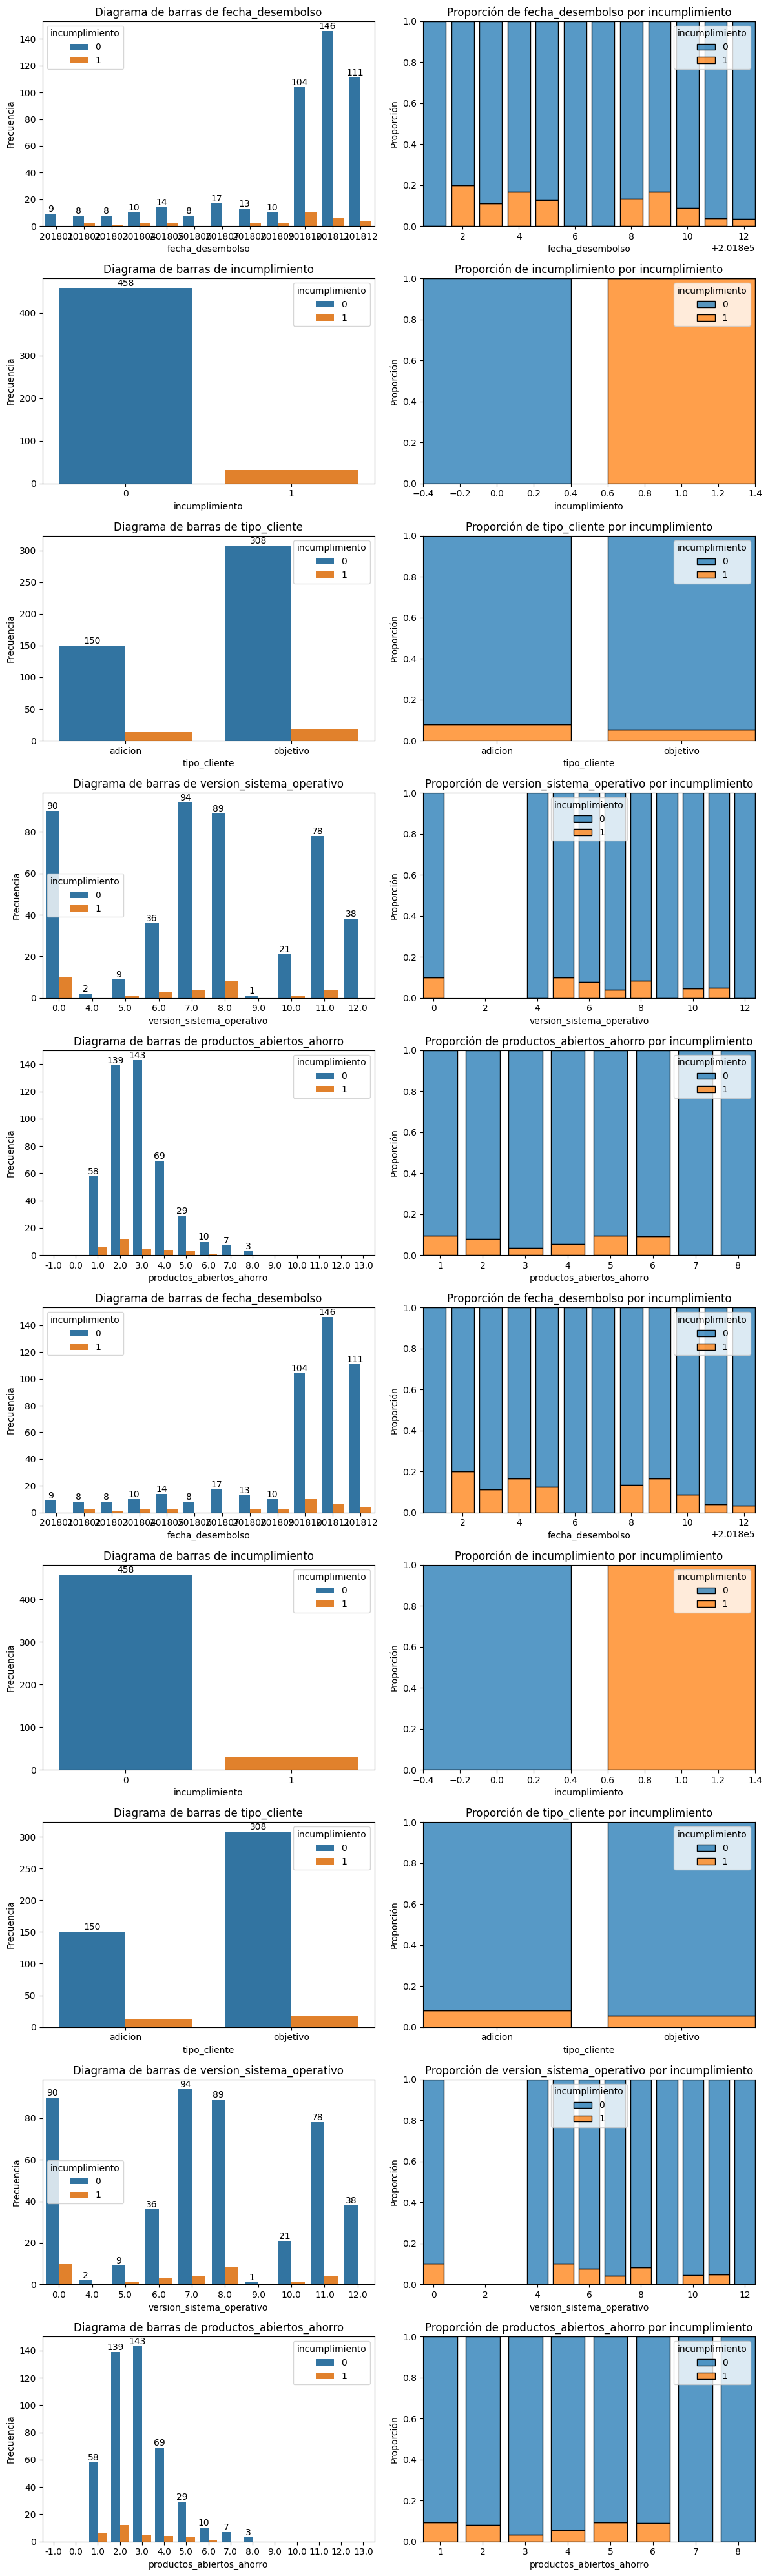

In [32]:
utils.graficar_categoricas(df=train_data, categorias= categoricas, hue = 'incumplimiento' )

`Insigths`

 1) Desbalanceo: En general, la variable de incumplimiento presenta un desbalanceo fuerte entre las dos categorias. Esto implica que de alguna manera, los datos estan sobrecargados de una categoria respecot a la otra. **Esto representa un primer desafio para el mdelo de clasificacion dado que no se puede mdelar una categoria muy sobrecargada**
 
 2) Tipo de cliente:  La mayoria de los datos hacen parte de la categoria 'adicion' es decir; no de la poblacion objetivo. Estop **podría** ser un problema si los datos de la poblacion de adiccion difieren de la poblacion objetivo puesto que al ser una proporcion mayor a lo que se tiene, el modelo podria tomar los datos de esta categoria como referencia principal a la hora de correr el modelo.
    Anexo a esto, tambien se observa que los datos en el cliente de tipo adicion **presenta un indice de incumplimiento de pago mayor** sin embargo esto plantea una pregunta. ¿Es esto por la naturaleza del fenomeno o responde al hecho de que, los datos estan mas cargados en la categoria adiccion y simplemente hay mas personas allí?
    
3) Sistema operativo: La mayoria de los clientes tienen preferencia por los sistemas operativo entre 0,7,8 y 11 aunque, no parece hbaer una tendencia clara respecto al incumplimineto. 

4) Fecha de Desembolso: Se organiza por fecha y se hace un conteo de ambas categorias. No se observa una diferencia significativa respecto a la **proporcion** de incumplimientos a lo largo del tiempo.  


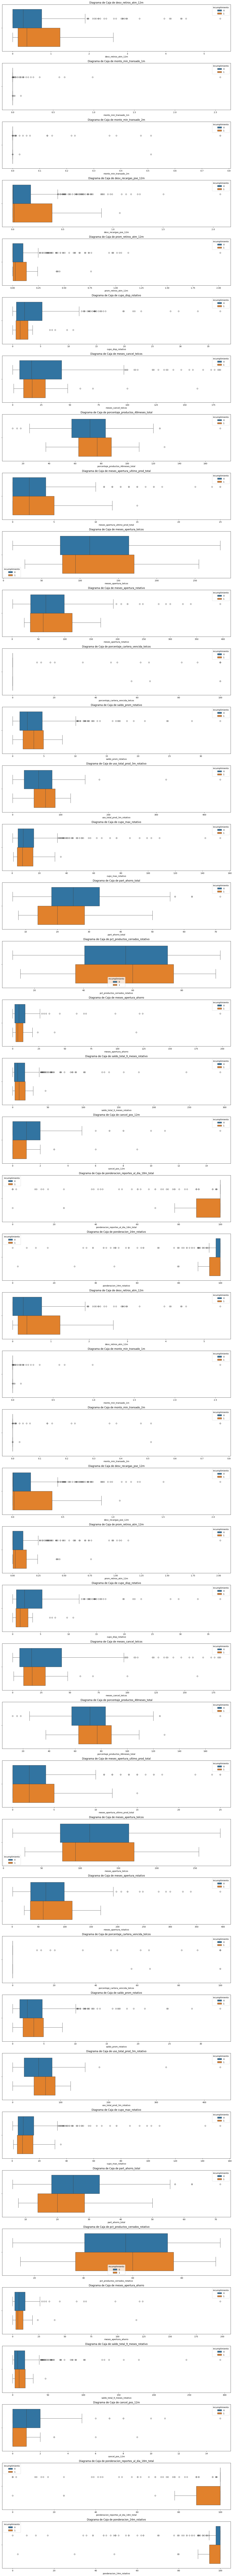

In [33]:
continuas.remove('id_cliente')
plt.figure(figsize=(16, len(continuas) * 4))
for i, variable in enumerate(continuas):
    plt.subplot(len(continuas), 1, i + 1)
    sns.boxplot(data=train_data, x=variable,  hue = 'incumplimiento')
    plt.title(f'Diagrama de Caja de {variable}')
    plt.xlabel(variable)

plt.tight_layout()
plt.show()

`Insigths`

### Análisis de Boxplots y Conclusiones

1. **Identificación de Outliers**:
   - Varias de las variables presentan valores atípicos (outliers), representados por puntos fuera de los límites de los boxplots. Estos outliers pueden tener un impacto significativo en el análisis o modelos predictivos y deben ser revisados.

2. **Distribuciones Asimétricas**:
   - Algunas variables muestran distribuciones sesgadas, lo que puede sugerir la necesidad de transformaciones (como el logaritmo o la normalización) para mejorar la simetría de los datos.

3. **Concentración de Datos**:
   - Existen variables donde los datos están altamente concentrados en un rango pequeño, mientras que pocas observaciones se desvían del promedio. Esto indica un comportamiento homogéneo en muchas de las variables.

4. **Variabilidad entre Variables**:
   - Algunas variables presentan una alta dispersión (cajas más anchas en los boxplots), mientras que otras tienen una variabilidad baja (cajas más estrechas). Esto muestra que ciertos atributos son más heterogéneos que otros.

### Recomendaciones:

Hasta este punto el analisis de calidad de la informacion ha servido para identificar sobre todo **calidad de los datos** ahora, se propone realizar un analisis de correlacion entre variables no sin antes mencionar que:

- **Tratamiento de Outliers**: Los graficos de boxplot identifican varios outliers, distribuciones sesgadas (asimetricas) y demas cosas interesantes. Sin embargo, el grafico de boxplot presupone de fondo una distribucionl a los datos. Si este no es el caso, seria incorrecto interprtarlo. De manera visual y rapida permite comparar diferencia entre medias entre grupos y demas.
  
- **Transformaciones de Variables**: Los datos a la hora de realizar el modelo seran procesados mediante algun algoritmo de escalamiento, vease estandarizando los datos u otra normalizacion al proceso que tenga sentido. 

# Correlacion

Vamos a intentr identificar algun tipo de correlacion entre variables. Ahora, teniendo en cuenta la naturaleza de la variable objetivo, seria bueno tambien identificar corrrelaciones entre variables categoricas. 



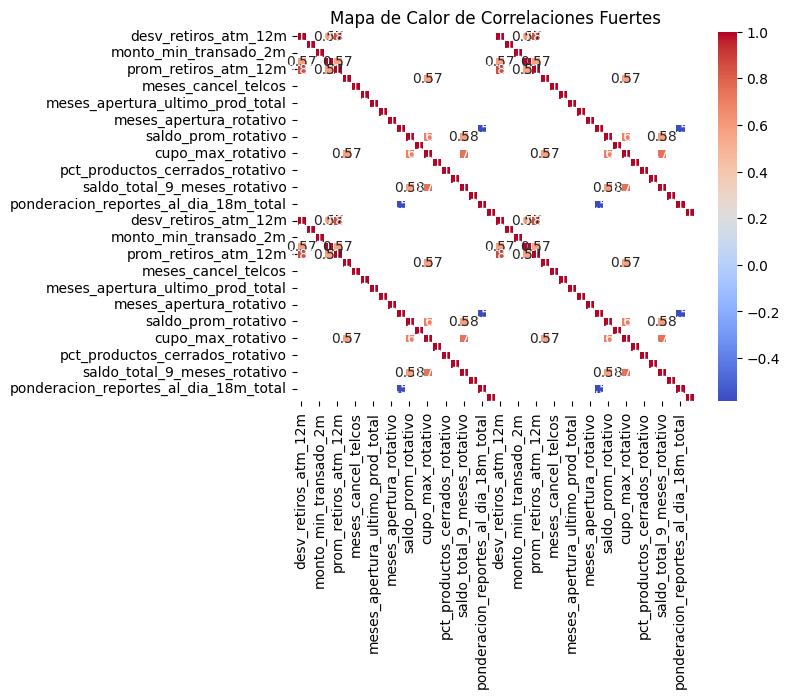

In [49]:
# Filtrar las correlaciones fuertes
correlacion = train_data[continuas].corr()
correlacion_fuerte = correlacion[(correlacion >= 0.5) | (correlacion <= -0.5)]
sns.heatmap(correlacion_fuerte, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones Fuertes')
plt.show()


No hay valores significativos en las correlaciones.

# Escalado de datos

Se procede a escalar las variables numericas. 



In [51]:
scaler = StandardScaler()
train_data[continuas] = scaler.fit_transform(train_data[continuas])

In [ ]:
# Getting dummies: vamos por ridge y lsasso
train_data_encoded = pd.get_dummies(train_data, drop_first=True)
train_data_encoded.shape